## Project 03 - Poverty
### Analyzing poverty based on demographic features
### Max Lan

### Primary Metric:
**As the goal of this exercise is to maximize the efficiency of policies aimed at assisting those in poverty, precision was chosen as the primary metric for any modelling.**

### Supporting files:
**There is a number of supporting files as mentioned in the comments throughout the notebook below and in the markdown file.**

### Import packages

In [1]:
import sys
sys.path
sys.path.append("/anaconda3/envs/metis/lib/python3.7/site-packages")

%pylab inline
%config InlineBackend.figure_formats = ['retina']

from collections import Counter

from statistics import mean
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold

from xgboost import XGBClassifier
from xgboost import plot_importance

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Due to installation path, the path for the module below was changed.
sys.path.append("/anaconda3/envs/metis/lib/python3.6/site-packages")

from mlxtend.plotting import plot_decision_regions #plotting regions

### Read and clean data

In [3]:
df_2017 = pd.read_csv('usa_00006.csv')

In [4]:
# Filter for adults only (persons above 18):
df_2017.loc[(df_2017.AGE >= 18),:].count()

YEAR         2530726
DATANUM      2530726
SERIAL       2530726
CBSERIAL     2530726
HHWT         2530726
STATEFIP     2530726
METRO        2530726
CITY         2530726
GQ           2530726
OWNERSHP     2530726
OWNERSHPD    2530726
PERNUM       2530726
PERWT        2530726
NCHILD       2530726
SEX          2530726
AGE          2530726
MARST        2530726
BPL          2530726
BPLD         2530726
HCOVANY      2530726
EDUC         2530726
EDUCD        2530726
EMPSTAT      2530726
EMPSTATD     2530726
OCC          2530726
IND          2530726
POVERTY      2530726
MIGRATE1     2530726
MIGRATE1D    2530726
dtype: int64

In [5]:
df_2017.count

<bound method DataFrame.count of          YEAR  DATANUM   SERIAL       CBSERIAL  HHWT  STATEFIP  METRO  CITY  \
0        2017        1        1  2017000000016   206         1      0     0   
1        2017        1        2  2017000000031    45         1      0     0   
2        2017        1        3  2017000000061   136         1      0     0   
3        2017        1        3  2017000000061   136         1      0     0   
4        2017        1        3  2017000000061   136         1      0     0   
5        2017        1        4  2017000000158    19         1      0     0   
6        2017        1        4  2017000000158    19         1      0     0   
7        2017        1        4  2017000000158    19         1      0     0   
8        2017        1        4  2017000000158    19         1      0     0   
9        2017        1        4  2017000000158    19         1      0     0   
10       2017        1        5  2017000000159    21         1      0     0   
11       2017      

In [6]:
# Filter for adults only (persons above 18):
df = df_2017.loc[(df_2017.AGE >= 18),:].copy()

# Generate unique identifier for each person
df['UNIQUE_ID'] = df['YEAR'].map(str) + df['DATANUM'].map(str) + \
                     df['SERIAL'].map(str) + df['PERNUM'].map(str)

# Set poverty binary (less than 100% of poverty level is 1)
df['POVERTY_BIN'] = np.where(df['POVERTY'] <= 100, 1,0)

# Keep only relevant columns as a copy of the original dataframe.
model_cols = ['UNIQUE_ID', 'PERWT', 'POVERTY_BIN', 'AGE', 'MIGRATE1', 'NCHILD', 'BPL', \
              'EDUC', 'MARST', 'EMPSTAT', 'SEX', 'HCOVANY', 'STATEFIP']

df_M = df[model_cols].copy()

# Set 0's to nulls (eliminates values that are actually N/A, but coded as 0 in the base data)
null_cols = ['MIGRATE1', 'EDUC', 'EMPSTAT']

df_M.loc[:, null_cols] = df_M.loc[:, null_cols].replace({0:np.nan})

# Drop nulls
df_M = df_M.dropna()

### Feature Engineering: generate binary features and dummies

In [7]:
# Generate international migration binary
df_M['MIGRATE_BIN'] = np.where(df_M['MIGRATE1'] == 4, 1,0)

# Generate born within the US binary
df_M['BPL_BIN'] = np.where(df_M['BPL'] <= 120, 1,0)

# Generate marriage binary (currently married = 1, not ever married or divorced = 0)
df_M['MARST_BIN'] = np.where(df_M['MARST'] <= 2, 1,0)

# Generate education bins (middle school only, high school only, 4 years college, 4+ years college)
educ_bins = [0, 2, 6, 10, 11]
educ_labels = ['LOW_ED', 'HIGH_SCH_ED', 'UNDERGRAD_ED', 'GRAD_ED']

df_M['EDUC_CAT'] = pd.cut(df_M['EDUC'], educ_bins, labels = educ_labels, include_lowest = True)

# Generate employment bins
df_M.loc[df_M['EMPSTAT'] == 1, 'EMPSTAT'] = 'EMPLOYED'
df_M.loc[df_M['EMPSTAT'] == 2, 'EMPSTAT'] = 'UNEMPLOYED'
df_M.loc[df_M['EMPSTAT'] == 3, 'EMPSTAT'] = 'N_LABOR'

# Generate gender binary
df_M['SEX'] = np.where(df_M['SEX'] == 2, 'MALE', 'FEMALE')

# Generate health coverage binary
df_M['HCOVANY'] = np.where(df_M['HCOVANY'] == 2, 1, 0)

# Replace state values with initials for easier identification
state_name_dict = {1:'AL', 2: 'AK', 4: 'AZ', 5: 'AR', 6: 'CA', 8: 'CO', \
                   9: 'CT', 10: 'DE', 11: 'DC', 12: 'FL', 13: 'GA', \
                   15: 'HI', 16: 'ID', 17: 'IL', 18: 'IN', 19: 'IA', 20: 'KS', \
                   21: 'KY', 22: 'LA', 23: 'ME', 24: 'MD', 25: 'MA', \
                   26: 'MI', 27: 'MN', 28: 'MS', 29: 'MO', 30: 'MT', \
                   31: 'NE', 32: 'NV', 33: 'NH', 34: 'NJ', 35: 'NM', \
                   36: 'NY', 37: 'NC', 38: 'ND', 39: 'OH', 40: 'OK', \
                   41: 'OR', 42: 'PA', 44: 'RI', 45: 'SC', \
                   46: 'SD', 47: 'TN', 48: 'TX', 49: 'UT', 50: 'VT', 51:'VA', \
                   53: 'WA', 54: 'WV', 55: 'WI', 56: 'WY'}

df_M['STATEFIP'] = df_M['STATEFIP'].map(state_name_dict)

# Create dummy variables for education, employment, sex, and state. The first is used for individual analysis
# for each state (see State_Model_Regression.ipynb)
df_M_state = pd.get_dummies(df_M, columns = ['EDUC_CAT', 'EMPSTAT', 'SEX'], drop_first = True).reset_index()
df_M = pd.get_dummies(df_M, columns = ['EDUC_CAT', 'EMPSTAT', 'SEX', 'STATEFIP'], drop_first = True).reset_index()

### Data Visualization and feature analysis

0    0.848712
1    0.151288
Name: POVERTY_BIN, dtype: float64


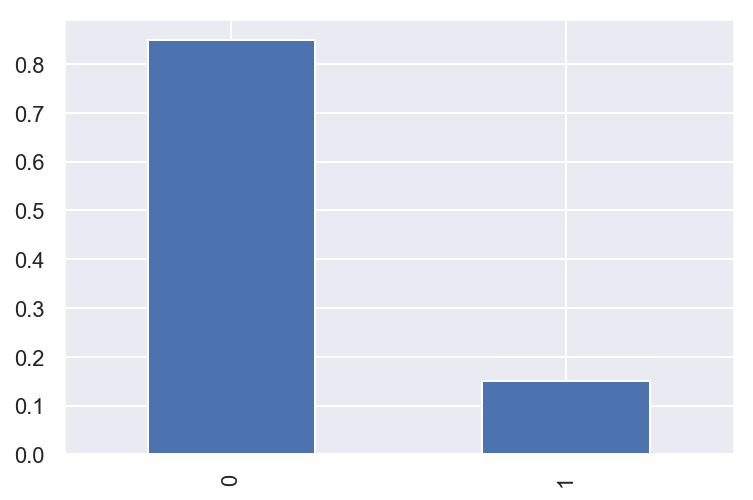

In [8]:
# Visualize % in poverty for overall data to determine whether class imbalance may be a factor.
# Noted class imbalance may influence later analysis due to approx 15% poverty rate (class 1).
target_pcts = df_M['POVERTY_BIN'].value_counts(normalize=True) 
print(target_pcts)
target_pcts.plot(kind='bar');

/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


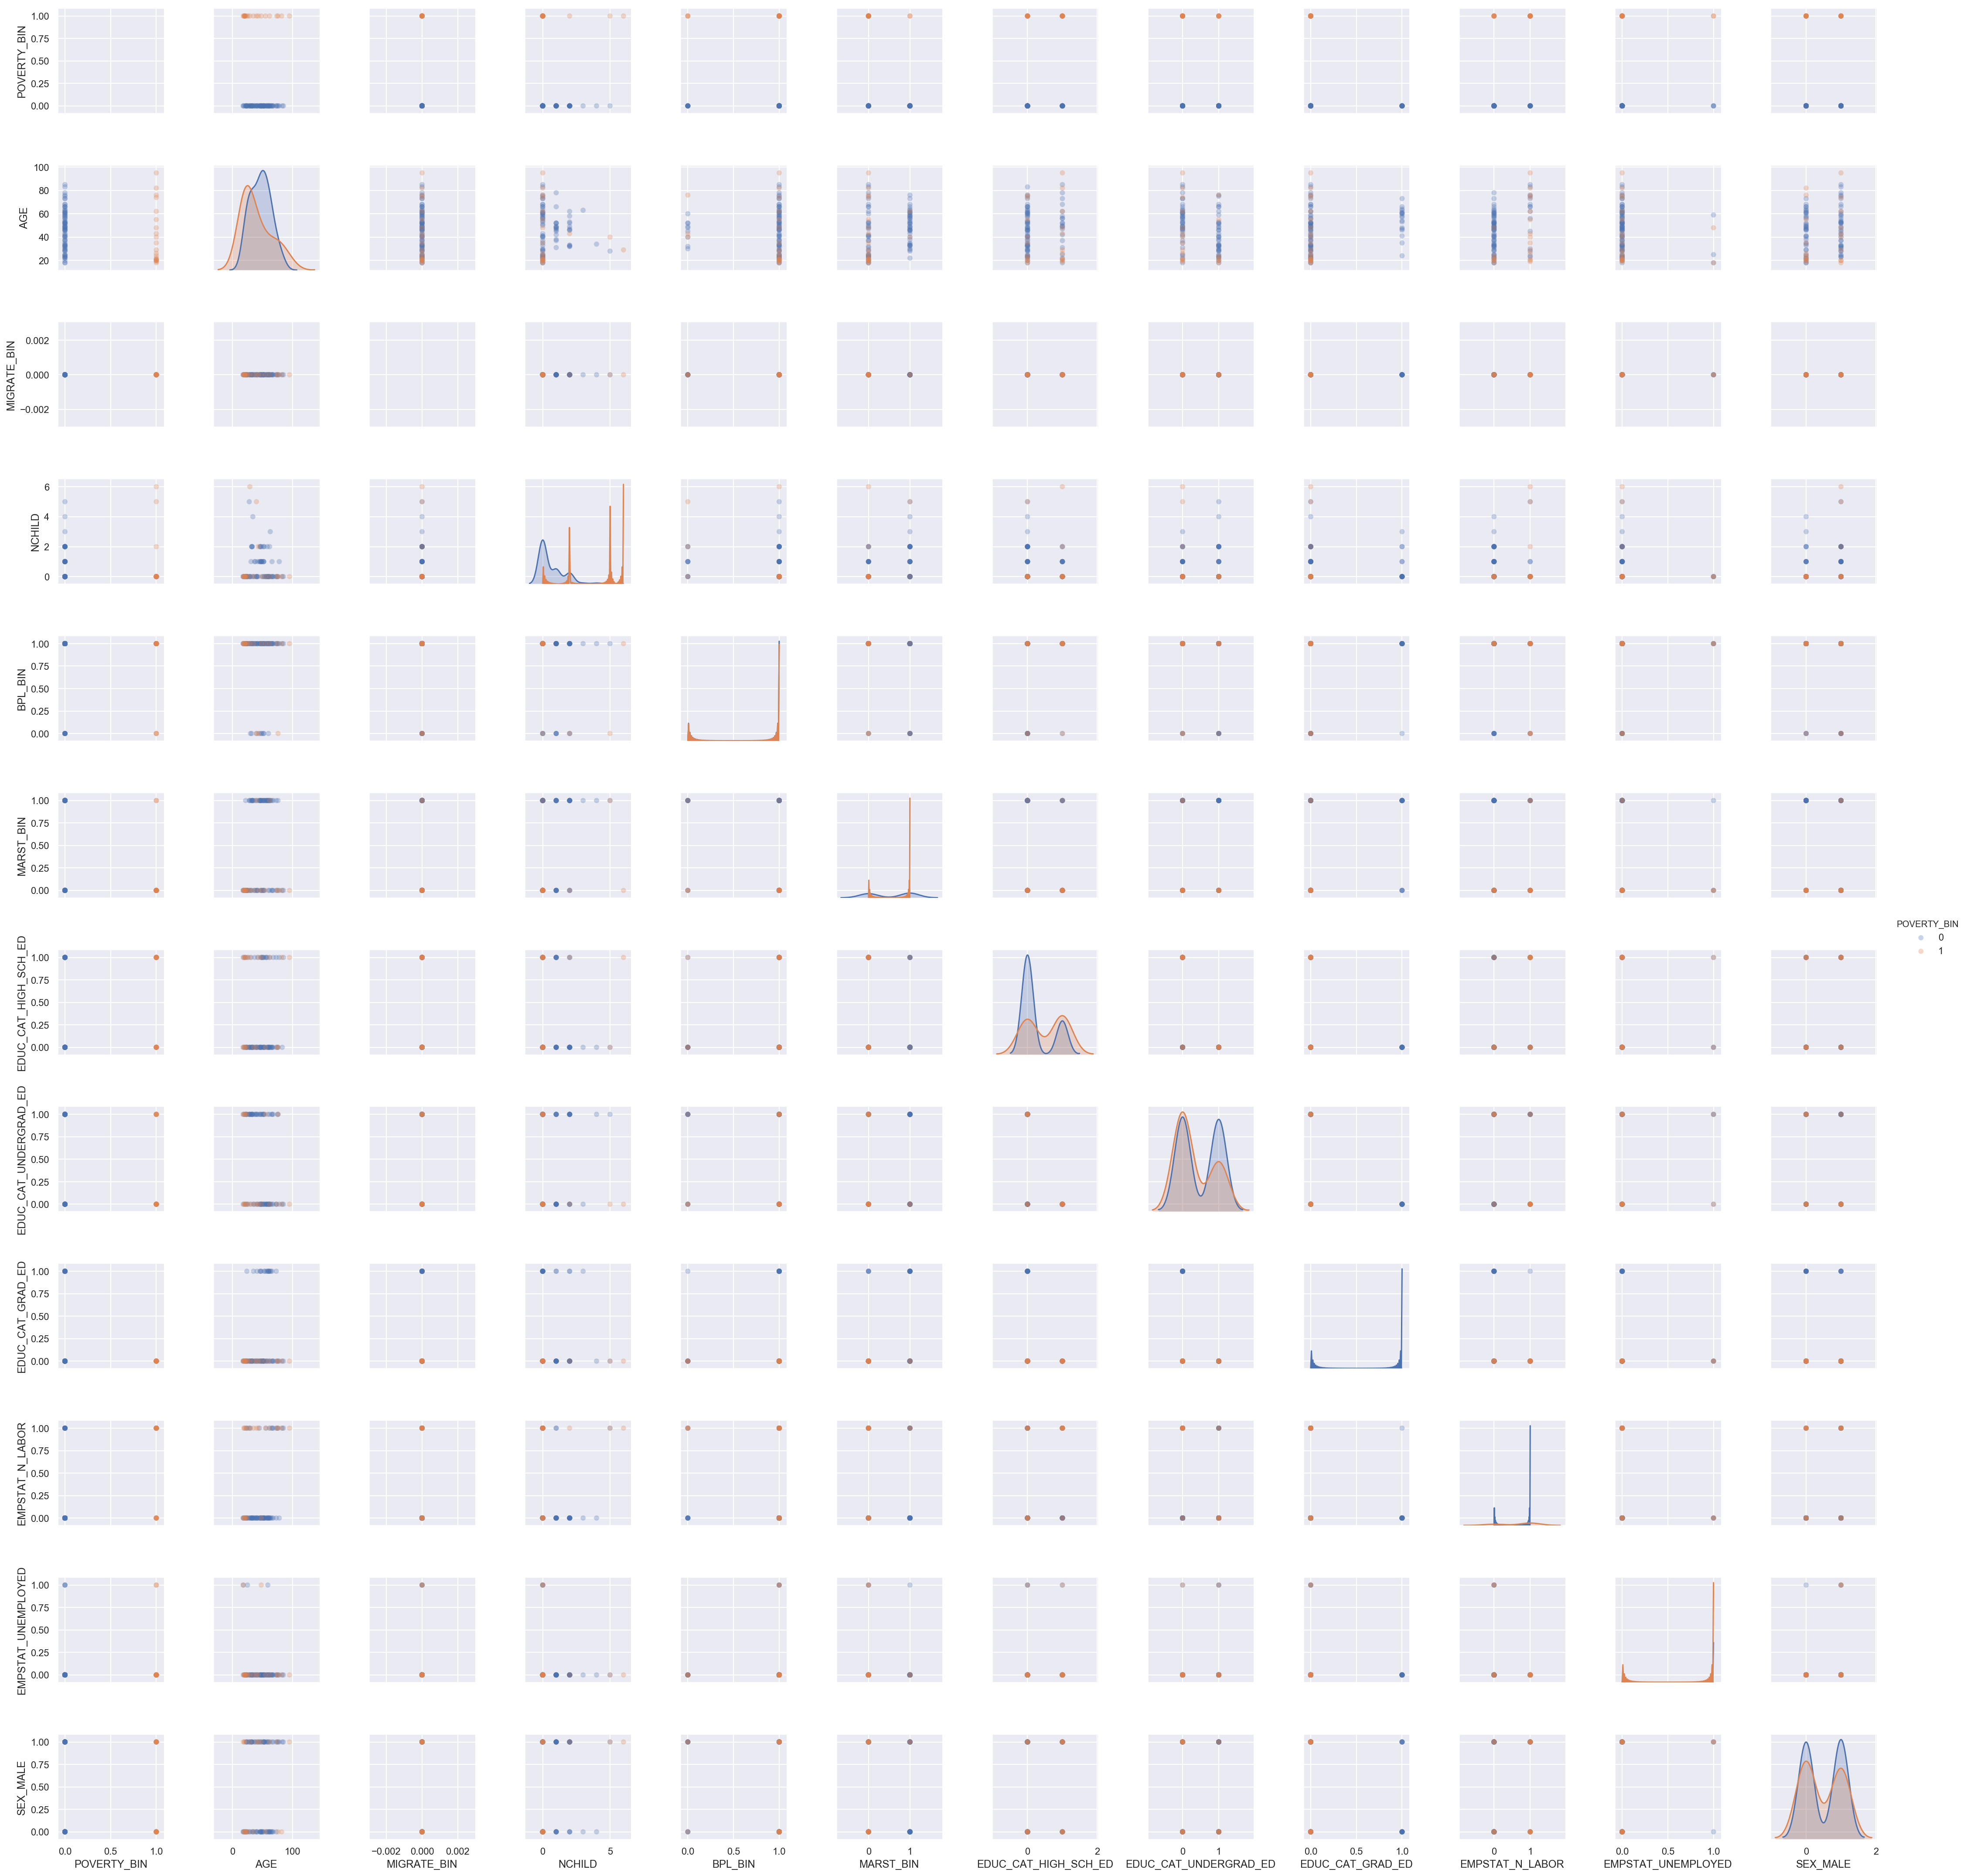

In [9]:
# Plot features to determine if they have an impact on the target (excludes dummies for states)
# Note: most of the plots have orange (class 1) distributions that vary from the blue distributions; this suggests
# the current features have an impact on the classification.
plot_cols = ['POVERTY_BIN', 'AGE', 'MIGRATE_BIN', 'NCHILD', 'BPL_BIN', 'MARST_BIN', 'EDUC_CAT_HIGH_SCH_ED', \
             'EDUC_CAT_UNDERGRAD_ED', 'EDUC_CAT_GRAD_ED', 'EMPSTAT_N_LABOR', 'EMPSTAT_UNEMPLOYED', 'SEX_MALE']

def plot_features(df, sample_size=500):
    
    sample = (df[plot_cols]
                .sample(100, random_state=20)) 
    
    sns.pairplot(sample,hue='POVERTY_BIN', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_M)

### Testing Helper Functions

In [11]:
# Prints the various metrics. Note that the models below were only judged on precision and AUC score for
# comparative purposes.

def scores(model, X_te, y_te, threshold):
    prediction = model.predict_proba(X_te)[:,1] > threshold 
    print(classification_report(y_te, prediction, digits = 4))

In [12]:
# Prints the ROC curve for a model; used to analyze the AUC score and compare models.
def print_ROC_curve(model, X_te, y_te):
    fpr, tpr, thresholds = roc_curve(y_te, model.predict_proba(X_te)[:,1])
    
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
#     plt.title(f'ROC curve for {model} model');
    print("ROC AUC score = ", roc_auc_score(y_te, model.predict_proba(X_te)[:,1]))

In [44]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (15,8), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", annot_kws = {"fontsize":fontsize})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Poverty', fontsize = 25)
    plt.xlabel('Predicted Poverty', fontsize = 25)
    return fig

### Test Split Data

In [14]:
X = df_M.drop(['UNIQUE_ID', 'MIGRATE1', 'POVERTY_BIN', 'BPL', 'EDUC', 'MARST'], axis = 1)
y = df_M[['POVERTY_BIN']]
X_init, X_te, y_init, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_tr, X_val, y_tr, y_val = train_test_split(X_init, y_init, test_size=0.25, random_state=42, stratify=y_init)

In [15]:
# Assign weight columns. As the data includes sample weights for each line (which indicate that each line is
# representative of 'PERWT' number of people), these weights must be included in any modeling to ensure the model
# is representative of the general population.
WT_init = X_init['PERWT'].copy()
WT_tr = X_tr['PERWT'].copy()
WT_val = X_val['PERWT'].copy()

In [16]:
# Feature scaling. In order to use one of the models below (Logistic Regression) and potentially examine other
# models, features are scaled using a normal distribution. Note that PERWT is a multiplicative factor that should
# not be scaled and is removed, then added back to the X_init (training + val) or X_tr (training) data sets.

# Warnings related to changing integer data types to floats due to scaling are ignored as they do not impact the
# analysis.

std = StandardScaler()

X_sets = [X_init, X_tr, X_val, X_te]
X_scale = []

for df in X_sets:
    df_sc = df.copy()
    df_scale_cols = df.drop(['PERWT'], axis = 1)
    scaler = std.fit_transform(df_scale_cols.values)
    df_sc.loc[:,list(df_scale_cols.columns)] = scaler
    X_scale.append(df_sc)

X_init_sc = X_scale[0]
X_tr_sc = X_scale[1]
X_val_sc = X_scale[2]
X_te_sc = X_scale[3]

X_val_sc = X_val_sc.drop(['index', 'PERWT'], axis = 1)
X_te_sc = X_te_sc.drop(['index', 'PERWT'], axis = 1)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

In [17]:
# Note: the dataframes below (the overall dataframe and a dataframe that does not include state dummy
# variables) are pickled for use in AWS_Models and State_Model_Regression.
    
# with open('df_M.pkl', 'wb') as f:
#     pickle.dump(df_M, f)

# with open('df_M_state.pkl', 'wb') as f:
#     pickle.dump(df_M_state, f)

### Helper function to run cross validation

In [18]:
#run the CV
def run_CV(model, X_init, y_init):
    
    scores=[]
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)

    for train_ind, val_ind in kf.split(X_init,y_init):

        X_tr, y_tr = X_init.iloc[train_ind,:], y_init.iloc[train_ind,:]
        X_val, y_val = X_init.iloc[val_ind,:], y_init.iloc[val_ind,:]
        
        WT_tr = X_tr[['PERWT']].copy()
        
        X_tr = X_tr.drop(columns = ['PERWT', 'index'])
        X_val = X_val.drop(columns = ['PERWT', 'index'])
        
        model.fit(X_tr, y_tr.values.ravel(), sample_weight = WT_tr.values.ravel())
        y_pred = model.predict(X_val)
        
        scores.append(precision_score(y_val, y_pred))
    
    print(1)
    
    return scores

### Logistic Regression CV

In [ ]:
# Model run and pickled for efficiency
lrCV = LogisticRegressionCV(solver = 'lbfgs', scoring = 'precision', max_iter = 1000, cv = 5, 
                            class_weight = 'balanced', random_state = 42)
lrCV_fit = lrCV.fit(X_init.drop(['index', 'PERWT'], axis = 1), y_init.values.ravel(), \
                                    sample_weight = WT_init.values.ravel())

In [17]:
# Output above pickled as 'lrCV_local.pkl'

with open('lrCV_local.pkl', 'rb') as f:
    lrCV = pickle.load(f)

In [18]:
# Average precision of 0.376
print('Average model precision:', np.mean([np.mean(score) for score in lrCV.scores_[1]]))

Average model precision: 0.3764181424052825


In [19]:
# Examination of coefficients in the regression analysis. Note that being out of the labor force or unemployed
# have the strongest positive impact on poverty, while being married, highly educated, or older have the strongest
# negative impacts.
sorted(list(zip(lrCV.coef_[0], X_init.drop(['index', 'PERWT'], axis = 1).columns)), reverse = True)

[(0.9592455530619066, 'EMPSTAT_N_LABOR'),
 (0.2591571513576943, 'EMPSTAT_UNEMPLOYED'),
 (0.19491813234284014, 'NCHILD'),
 (0.06714548682870002, 'MIGRATE_BIN'),
 (0.051859505057910225, 'STATEFIP_KY'),
 (0.04665427368044379, 'STATEFIP_LA'),
 (0.04018686806041867, 'SEX_MALE'),
 (0.03563107912646334, 'STATEFIP_OH'),
 (0.03464804946090829, 'STATEFIP_NC'),
 (0.03318701602644222, 'STATEFIP_WV'),
 (0.032186493957639846, 'STATEFIP_MS'),
 (0.03218261041449654, 'STATEFIP_NM'),
 (0.029367460527454595, 'STATEFIP_MI'),
 (0.028101310129580236, 'STATEFIP_TN'),
 (0.028050061461518075, 'STATEFIP_AR'),
 (0.027986286689597184, 'STATEFIP_SC'),
 (0.02636444945461712, 'STATEFIP_PA'),
 (0.026179492858100804, 'STATEFIP_NY'),
 (0.026034901590299198, 'STATEFIP_MO'),
 (0.02563576031240637, 'STATEFIP_IA'),
 (0.02360802843645668, 'STATEFIP_IN'),
 (0.022600679616236144, 'STATEFIP_OK'),
 (0.02026553527637057, 'STATEFIP_GA'),
 (0.020109724056061155, 'STATEFIP_KS'),
 (0.019997183064734442, 'STATEFIP_AL'),
 (0.019246522

ROC AUC score =  0.8344316427084915


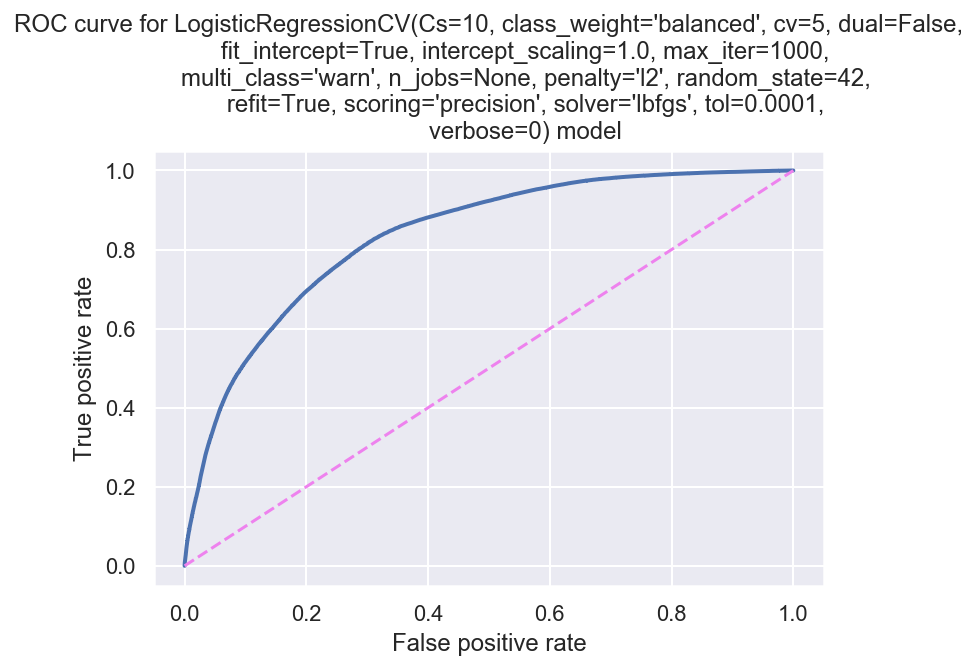

In [20]:
print_ROC_curve(lrCV, X_val_sc, y_val)

### Random Forest

In [20]:
# A randomforest model was run using a straight approach and a cross validation approach and were pickled
# accordingly for efficiency.
randomforest = RandomForestClassifier(n_estimators=100, n_jobs = -1, class_weight = 'balanced', random_state = 42)

# randomforest.fit(X_tr_sc.drop(['index','PERWT'], axis = 1), y_tr.values.ravel(), \
#                  sample_weight = WT_tr.values.ravel())

# randomforest_scores = run_CV(randomforest, X_init_sc, y_init)

In [21]:
# Output with CV scores written as 'randomforest_scores_local.pkl'
# Output with no CV written as 'randomforest_local_noCV.pkl'
# Output with CV written as 'randomforest_local.pkl'

with open('randomforest_local.pkl', 'rb') as f:
    randomforestCV = pickle.load(f)

with open('randomforest_scores_local.pkl', 'rb') as f:
    randomforest_scores = pickle.load(f)
    
with open('randomforest_local_noCV.pkl', 'rb') as f:
    randomforest_noCV = pickle.load(f)

In [22]:
# Average model precision using a cross-validation approach. 0.41, stronger than logistic regression above.
print('Average model precision:', np.mean(randomforest_scores))

Average model precision: 0.4168343917098289


In [23]:
# Feature importance per randomforest. Note that age is the largest, which may be in part due to its continuous
# nature and the impact it has (see logistic regression above)
sorted(list(zip(randomforest_noCV.feature_importances_, X_init.drop(['index', 'PERWT'], axis = 1).columns)), \
       reverse = True)

[(0.37441271551056743, 'AGE'),
 (0.1473719662727242, 'EMPSTAT_N_LABOR'),
 (0.1383448024683936, 'MARST_BIN'),
 (0.058659498091383294, 'NCHILD'),
 (0.03521943990563368, 'HCOVANY'),
 (0.027564145138580534, 'EMPSTAT_UNEMPLOYED'),
 (0.02082462485730728, 'EDUC_CAT_GRAD_ED'),
 (0.020682368605939288, 'EDUC_CAT_HIGH_SCH_ED'),
 (0.017136811903158734, 'SEX_MALE'),
 (0.01673133712720401, 'EDUC_CAT_UNDERGRAD_ED'),
 (0.015978185687727995, 'BPL_BIN'),
 (0.005144528835221234, 'STATEFIP_CA'),
 (0.004919747012880617, 'STATEFIP_TX'),
 (0.004656091997537855, 'STATEFIP_FL'),
 (0.004434546920795351, 'STATEFIP_NY'),
 (0.00441406659915688, 'MIGRATE_BIN'),
 (0.0041315490392051365, 'STATEFIP_IL'),
 (0.00369336681218421, 'STATEFIP_GA'),
 (0.0036791509269708915, 'STATEFIP_NC'),
 (0.0036027356336373897, 'STATEFIP_PA'),
 (0.0034461012520672994, 'STATEFIP_AZ'),
 (0.003363581543781522, 'STATEFIP_MI'),
 (0.0033527504503893884, 'STATEFIP_OH'),
 (0.003285431475110237, 'STATEFIP_VA'),
 (0.003159165388528174, 'STATEFIP_NJ

In [24]:
print(classification_report(y_val, randomforest_noCV.predict(X_val_sc)))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88    423484
           1       0.42      0.62      0.50     75489

   micro avg       0.81      0.81      0.81    498973
   macro avg       0.67      0.73      0.69    498973
weighted avg       0.85      0.81      0.83    498973



ROC AUC score =  0.8096787000036003


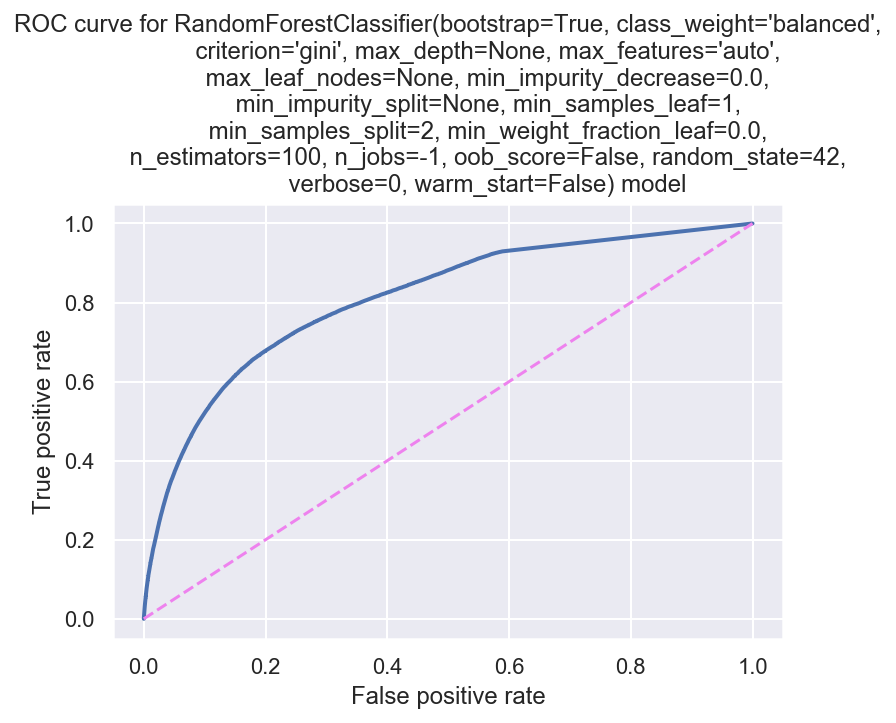

In [25]:
# Lower than the logistic regression. Now let's consider xgboost.
print_ROC_curve(randomforest_noCV, X_val_sc, y_val)

### XGBoost Model

In [19]:
# Used to address issues related to xgboost installation
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
# Run a xgb classifier using the training set data, scaled. Note that cross validation is not used for xgb.
xgb = XGBClassifier(learning_rate = 0.03, random_state=42)
xgb.fit(X_tr_sc.drop(['index','PERWT'], axis = 1), y_tr.values.ravel(), sample_weight = WT_tr.values.ravel())

In [20]:
# Multiple models were run based on varying learning rates. For the initial analysis, learning rate 0.03 was used.
# XGB classifier pickled as 'xgb_noCV.pkl' for learning_rate 0.1
# XGB classifier pickled as 'xgb_noCV_03.pkl' for learning_rate 0.03
# XGB classifier pickled as 'xgb_noCV_05.pkl' for learning_rate 0.05

with open('xgb_noCV_03.pkl', 'rb') as f:
    xgb = pickle.load(f)

In [21]:
# A strong precision score and confusion matrix.
precision_score(y_val, xgb.predict(X_val_sc))

0.7120926299356014

In [30]:
print(classification_report(y_val, xgb.predict(X_val_sc)))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92    423484
           1       0.71      0.15      0.24     75489

   micro avg       0.86      0.86      0.86    498973
   macro avg       0.79      0.57      0.58    498973
weighted avg       0.84      0.86      0.82    498973



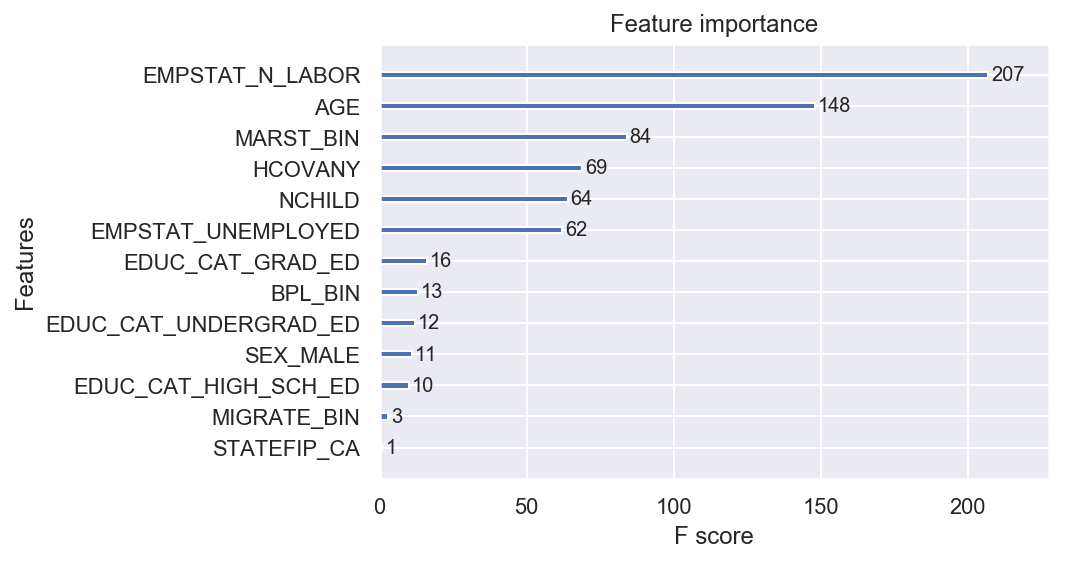

In [31]:
# Feature importances are in line with domain knowledge. being older or out of the labor force have the most
# impact, followed by being married. This does not tell us the direction of the impact; the logistic regression
# coefficients and domain knowledge will be used for these items instead.
plot_importance(xgb);

ROC AUC score =  0.8401828473788117


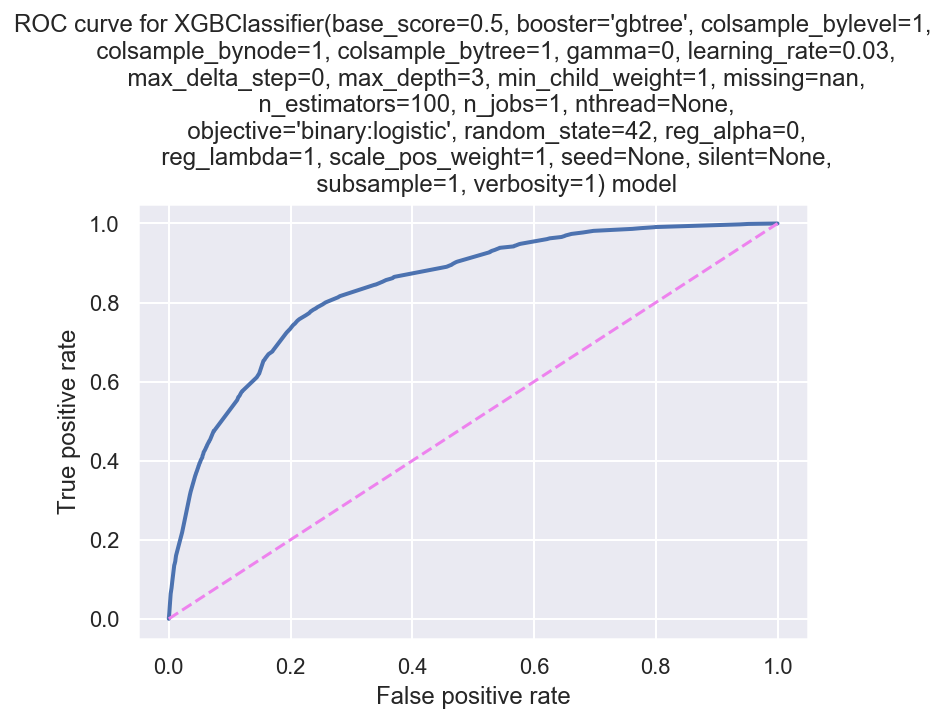

In [32]:
# Best AUC score and precision of the 3 models. Final decision is to use xgboost.
print_ROC_curve(xgb, X_val_sc, y_val)

### XGBoost GridsearchCV

In [33]:
# Within AWS_Model.py, AWS was used to perform a grid search to compare learning rates. The lines below load the
# results of a gridsearchCV wityh 3 folds, comparing a learning rate of 0.03, 0.05, and 0.07.
with open('AWS/xgb_grid_03_05.pkl', 'rb') as f:
    xgb_grid_03_05 = pickle.load(f)
    
with open('AWS/xgb_grid_05_07.pkl', 'rb') as f:
    xgb_grid_05_07 = pickle.load(f)

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserW

In [34]:
# Per the grid search, 0.03 appears to be the best learning rate for use, so no change is made to the model
# above.
print('Learning rate 0.03 vs. 0.05:', xgb_grid_03_05.best_params_)
print('Learning rate 0.05 vs. 0.07:', xgb_grid_05_07.best_params_)

Learning rate 0.03 vs. 0.05: {'learning_rate': 0.03}
Learning rate 0.05 vs. 0.07: {'learning_rate': 0.05}


### Final Analyses

ROC AUC score =  0.8344316427084915
ROC AUC score =  0.8096787000036003
ROC AUC score =  0.8401828473788117


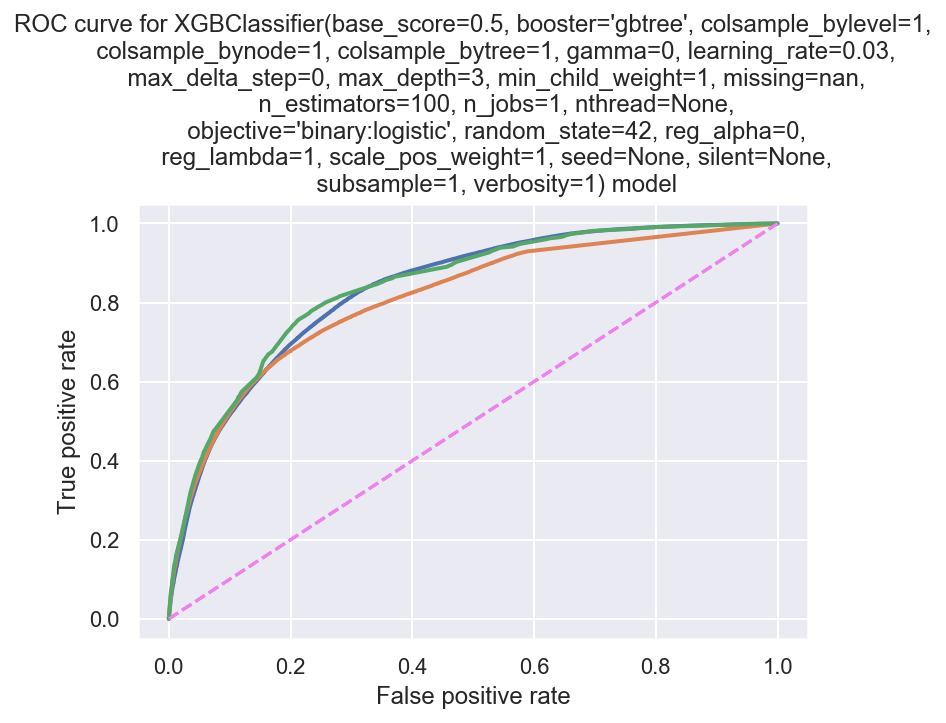

In [35]:
# Plot showing the various ROC curves. As they do not overlap or outperform each other significantly at specific
# points, the author determined there was no need to combine the models.
print_ROC_curve(lrCV, X_val_sc, y_val)
print_ROC_curve(randomforest_noCV, X_val_sc, y_val)
print_ROC_curve(xgb, X_val_sc, y_val)
plt.show()

In [37]:
# Prediction on test data
print(classification_report(y_te, xgb.predict(X_te_sc)))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92    423484
           1       0.71      0.14      0.24     75489

   micro avg       0.86      0.86      0.86    498973
   macro avg       0.79      0.57      0.58    498973
weighted avg       0.84      0.86      0.82    498973



### Additional figures (presentation purposes only)

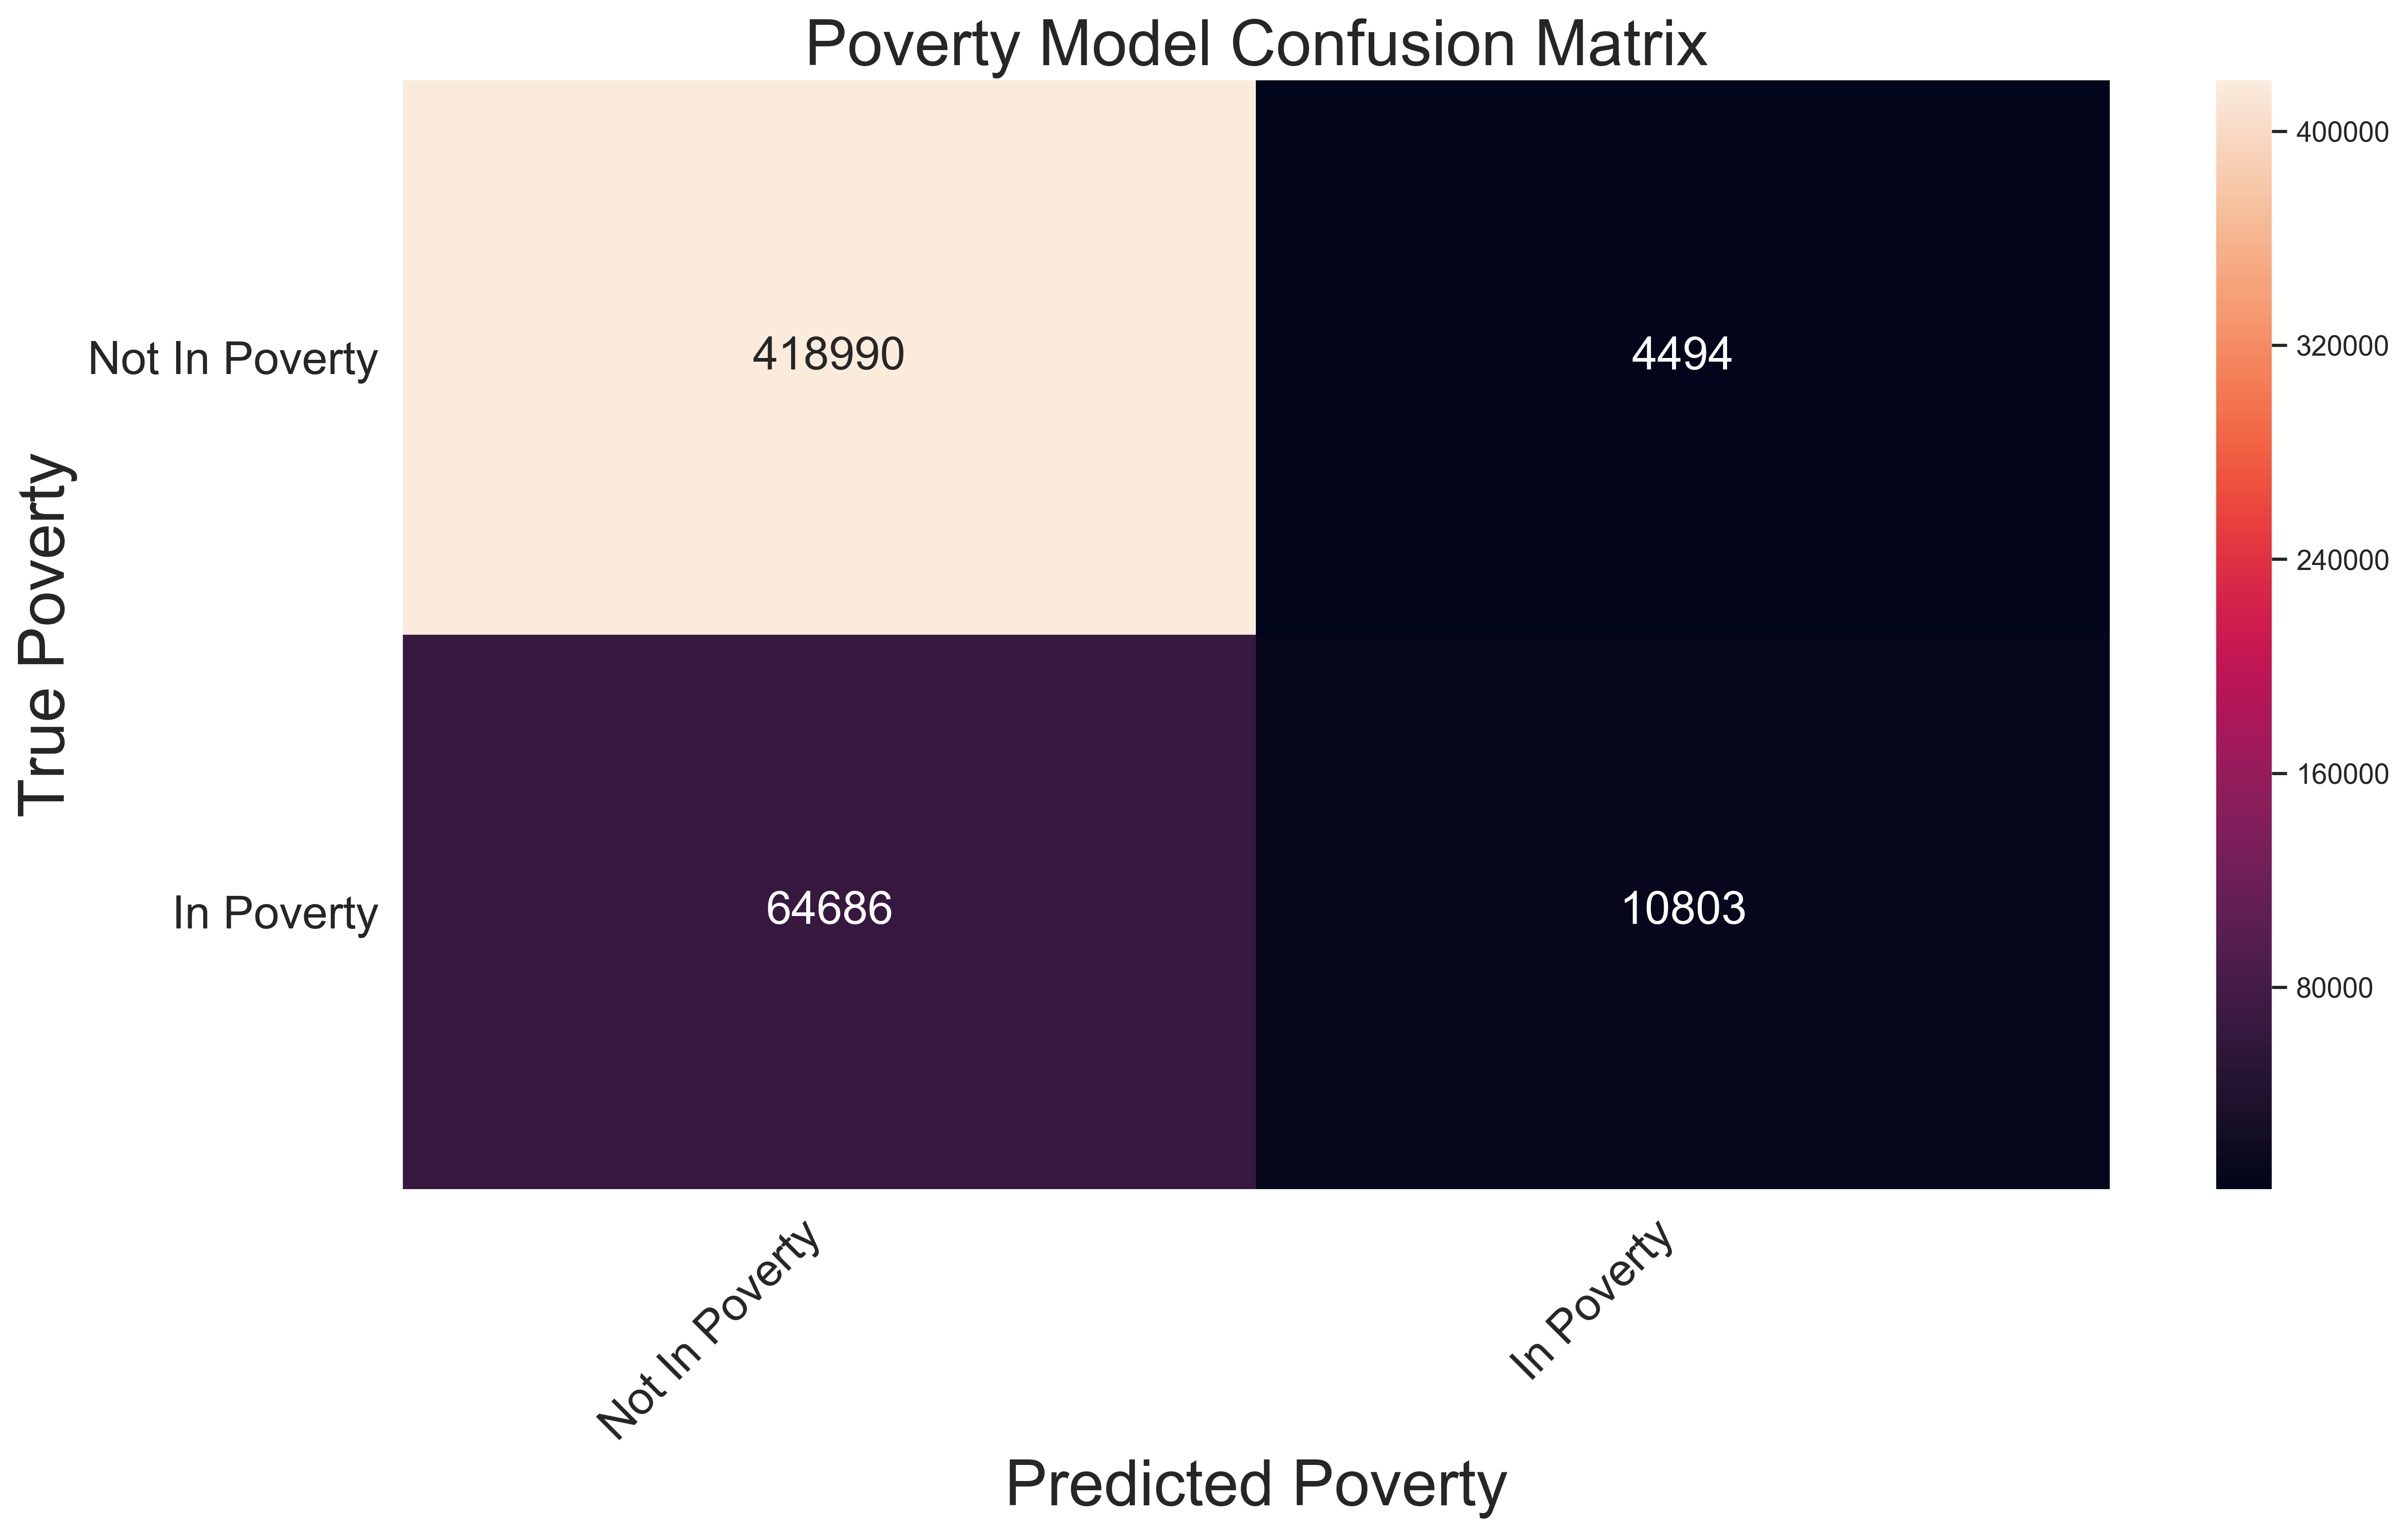

In [50]:
# Figure used for presentation purposes only
plt.rcParams["figure.dpi"] = 200
conf = print_confusion_matrix(confusion_matrix(y_te, xgb.predict(X_te_sc)), ['Not In Poverty', 'In Poverty'])
plt.title('Poverty Model Confusion Matrix', fontsize = 25)

# Saves the figure
plt.savefig("matrix.png", format="png", bbox_inches='tight');

In [70]:
# Prints the ROC curve for a model; used to analyze the AUC score and compare models.
def present_ROC_curve(model, X_te, y_te):
    fpr, tpr, thresholds = roc_curve(y_te, model.predict_proba(X_te)[:,1])
    
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.grid(False)

    plt.xlabel('False positive rate', fontsize = 25)
    plt.ylabel('True positive rate', fontsize = 25)
    plt.tick_params(axis = 'both', labelsize = 15)
    plt.title('Poverty Model ROC Curve', fontsize = 25)
    print("ROC AUC score = ", roc_auc_score(y_te, model.predict_proba(X_te)[:,1]))

ROC AUC score =  0.840038892196509


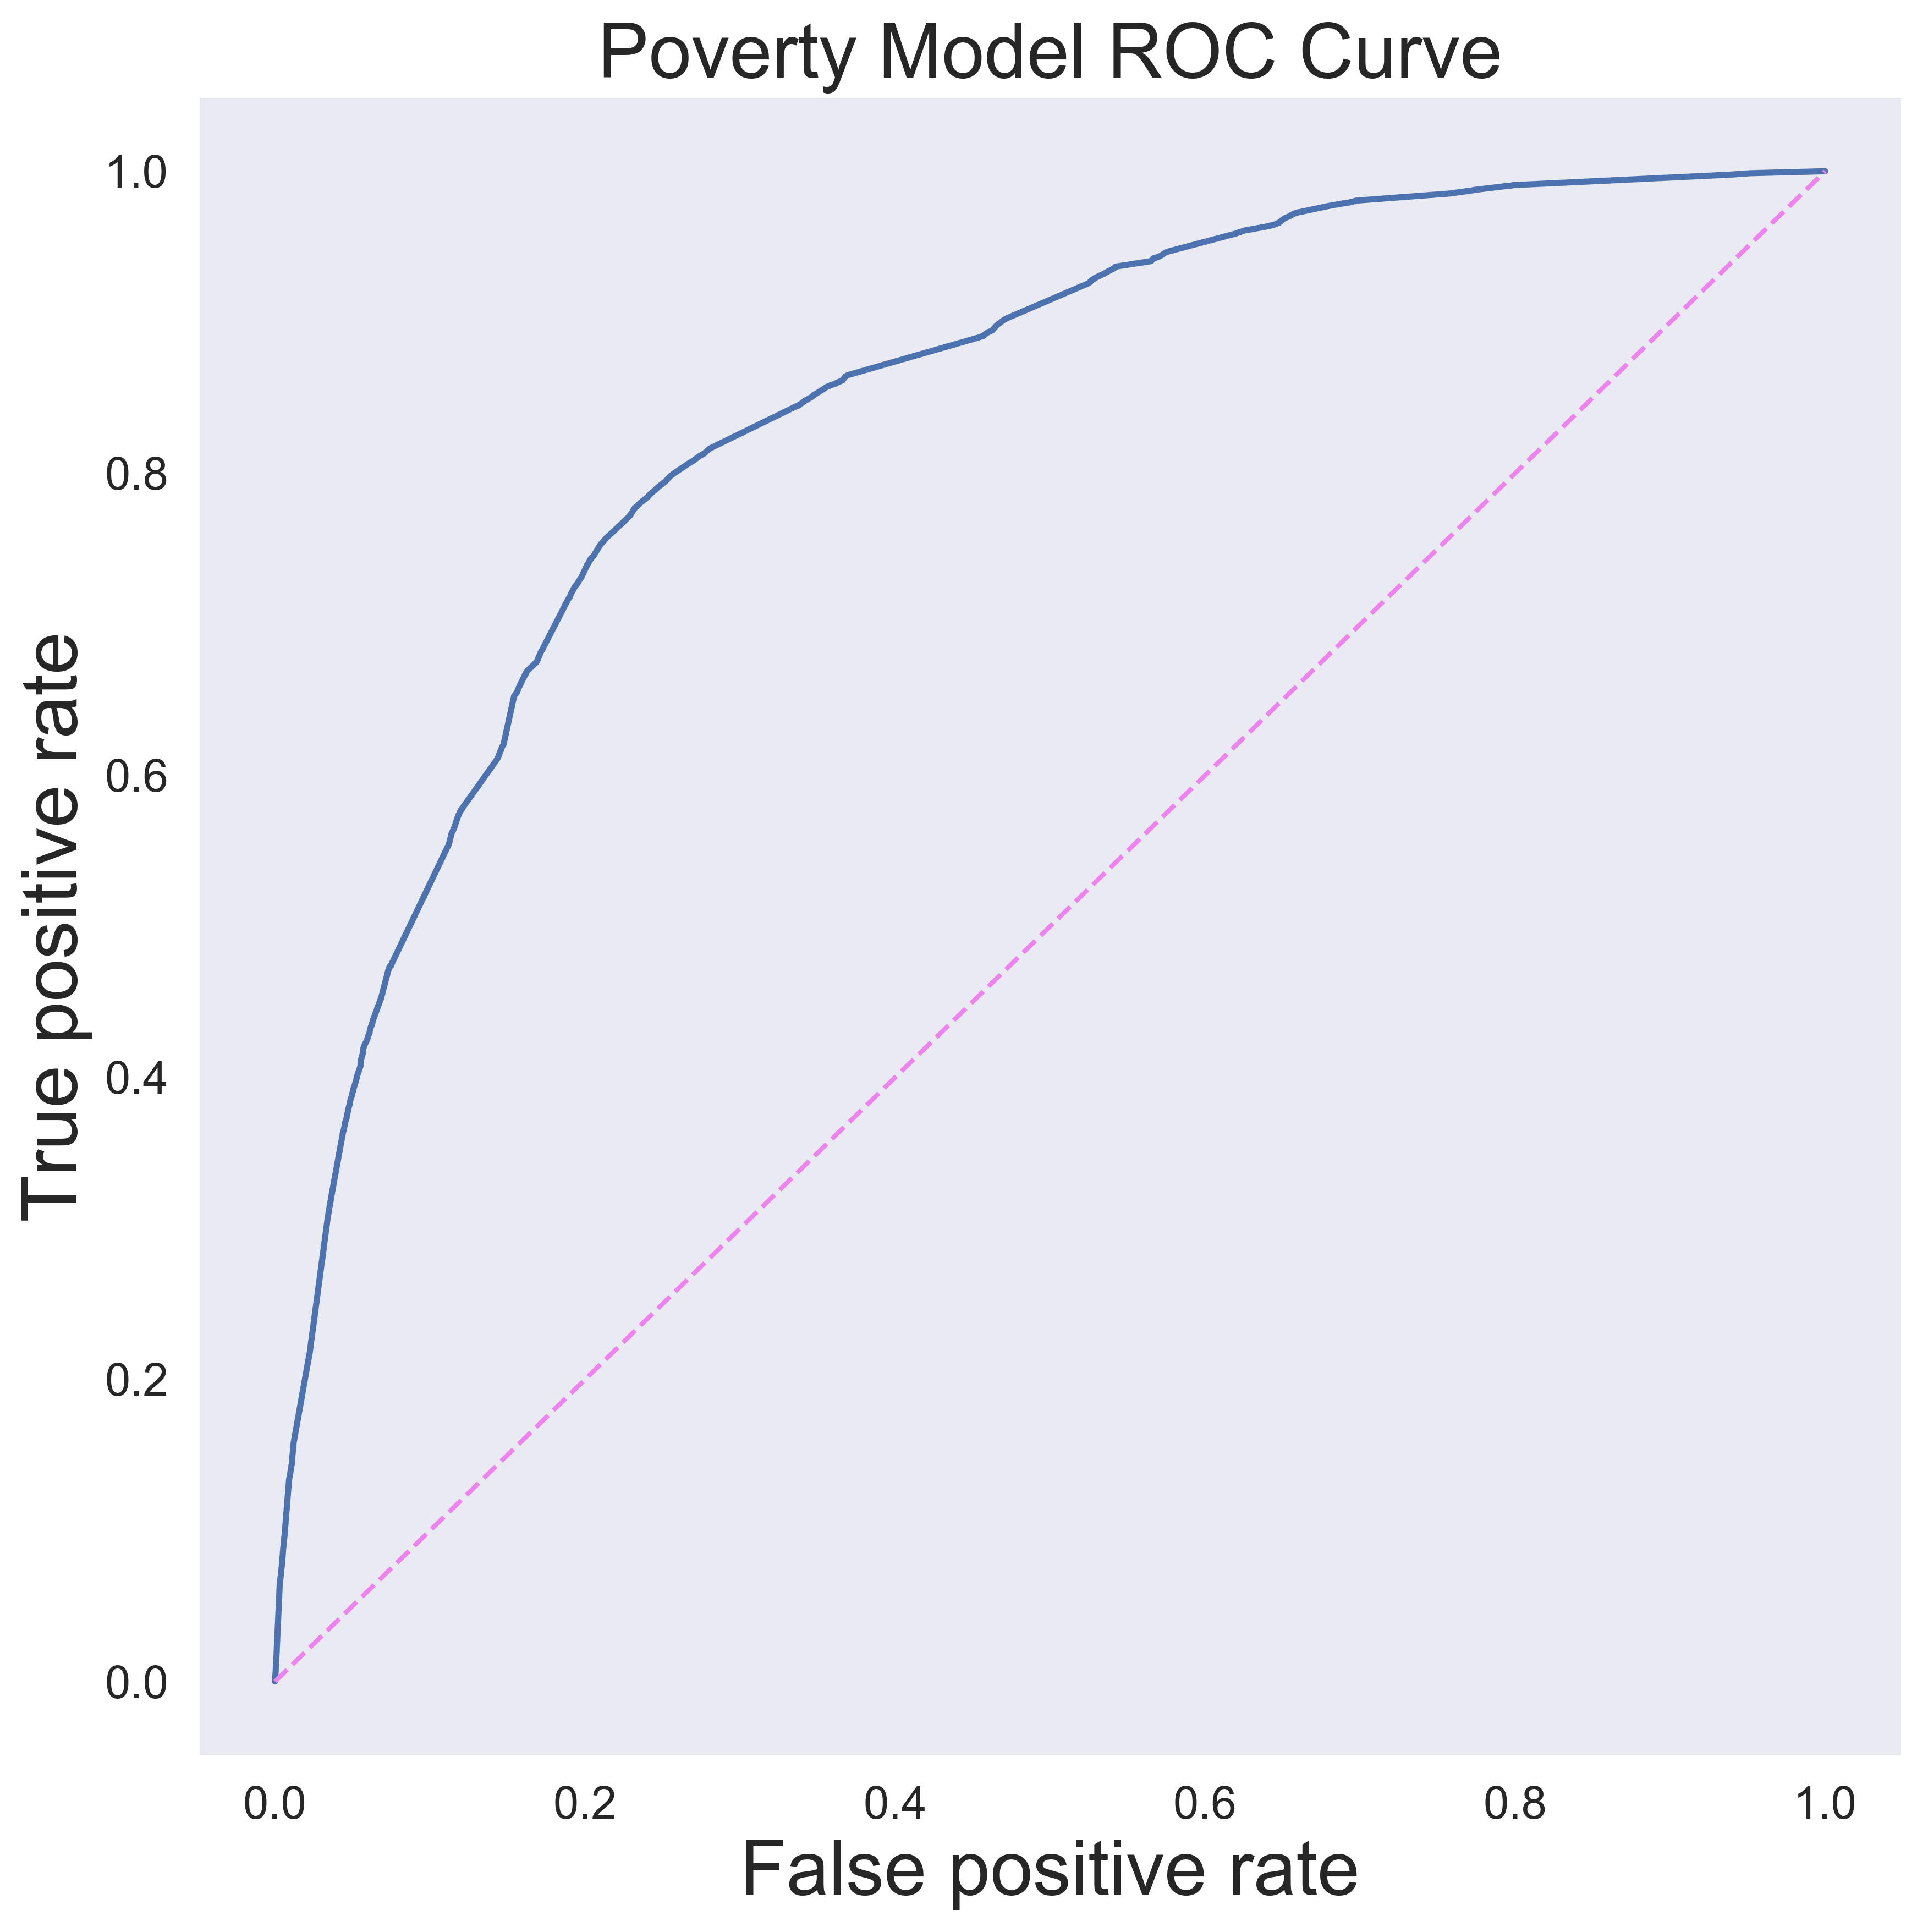

In [71]:
plt.rcParams["figure.dpi"] = 200
plt.figure(figsize=(10,10))
present_ROC_curve(xgb, X_te_sc, y_te)

# Saves the figure
plt.savefig("ROC.png", format="png", bbox_inches='tight', transparent=True);

In [89]:
# labels = list(xgb.get_booster().get_score(importance_type='weight').keys())
labels = ['Married', 'Not in Labor Force', 'Unemployed', 'Age', 'Health Insurance', '# of Children', \
          'Sex (Male)', 'High School Education', 'Foreign Born', 'Grad School Education', 'California', \
          'Undergrad Education', 'Immigrant (1 Year)']
values = xgb.get_booster().get_score(importance_type='weight').values()

new_dict = dict(zip(labels, values))
new_dict

{'Married': 84,
 'Not in Labor Force': 207,
 'Unemployed': 62,
 'Age': 148,
 'Health Insurance': 69,
 '# of Children': 64,
 'Sex (Male)': 11,
 'High School Education': 10,
 'Foreign Born': 13,
 'Grad School Education': 16,
 'California': 1,
 'Undergrad Education': 12,
 'Immigrant (1 Year)': 3}

AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

<Figure size 3600x2000 with 0 Axes>

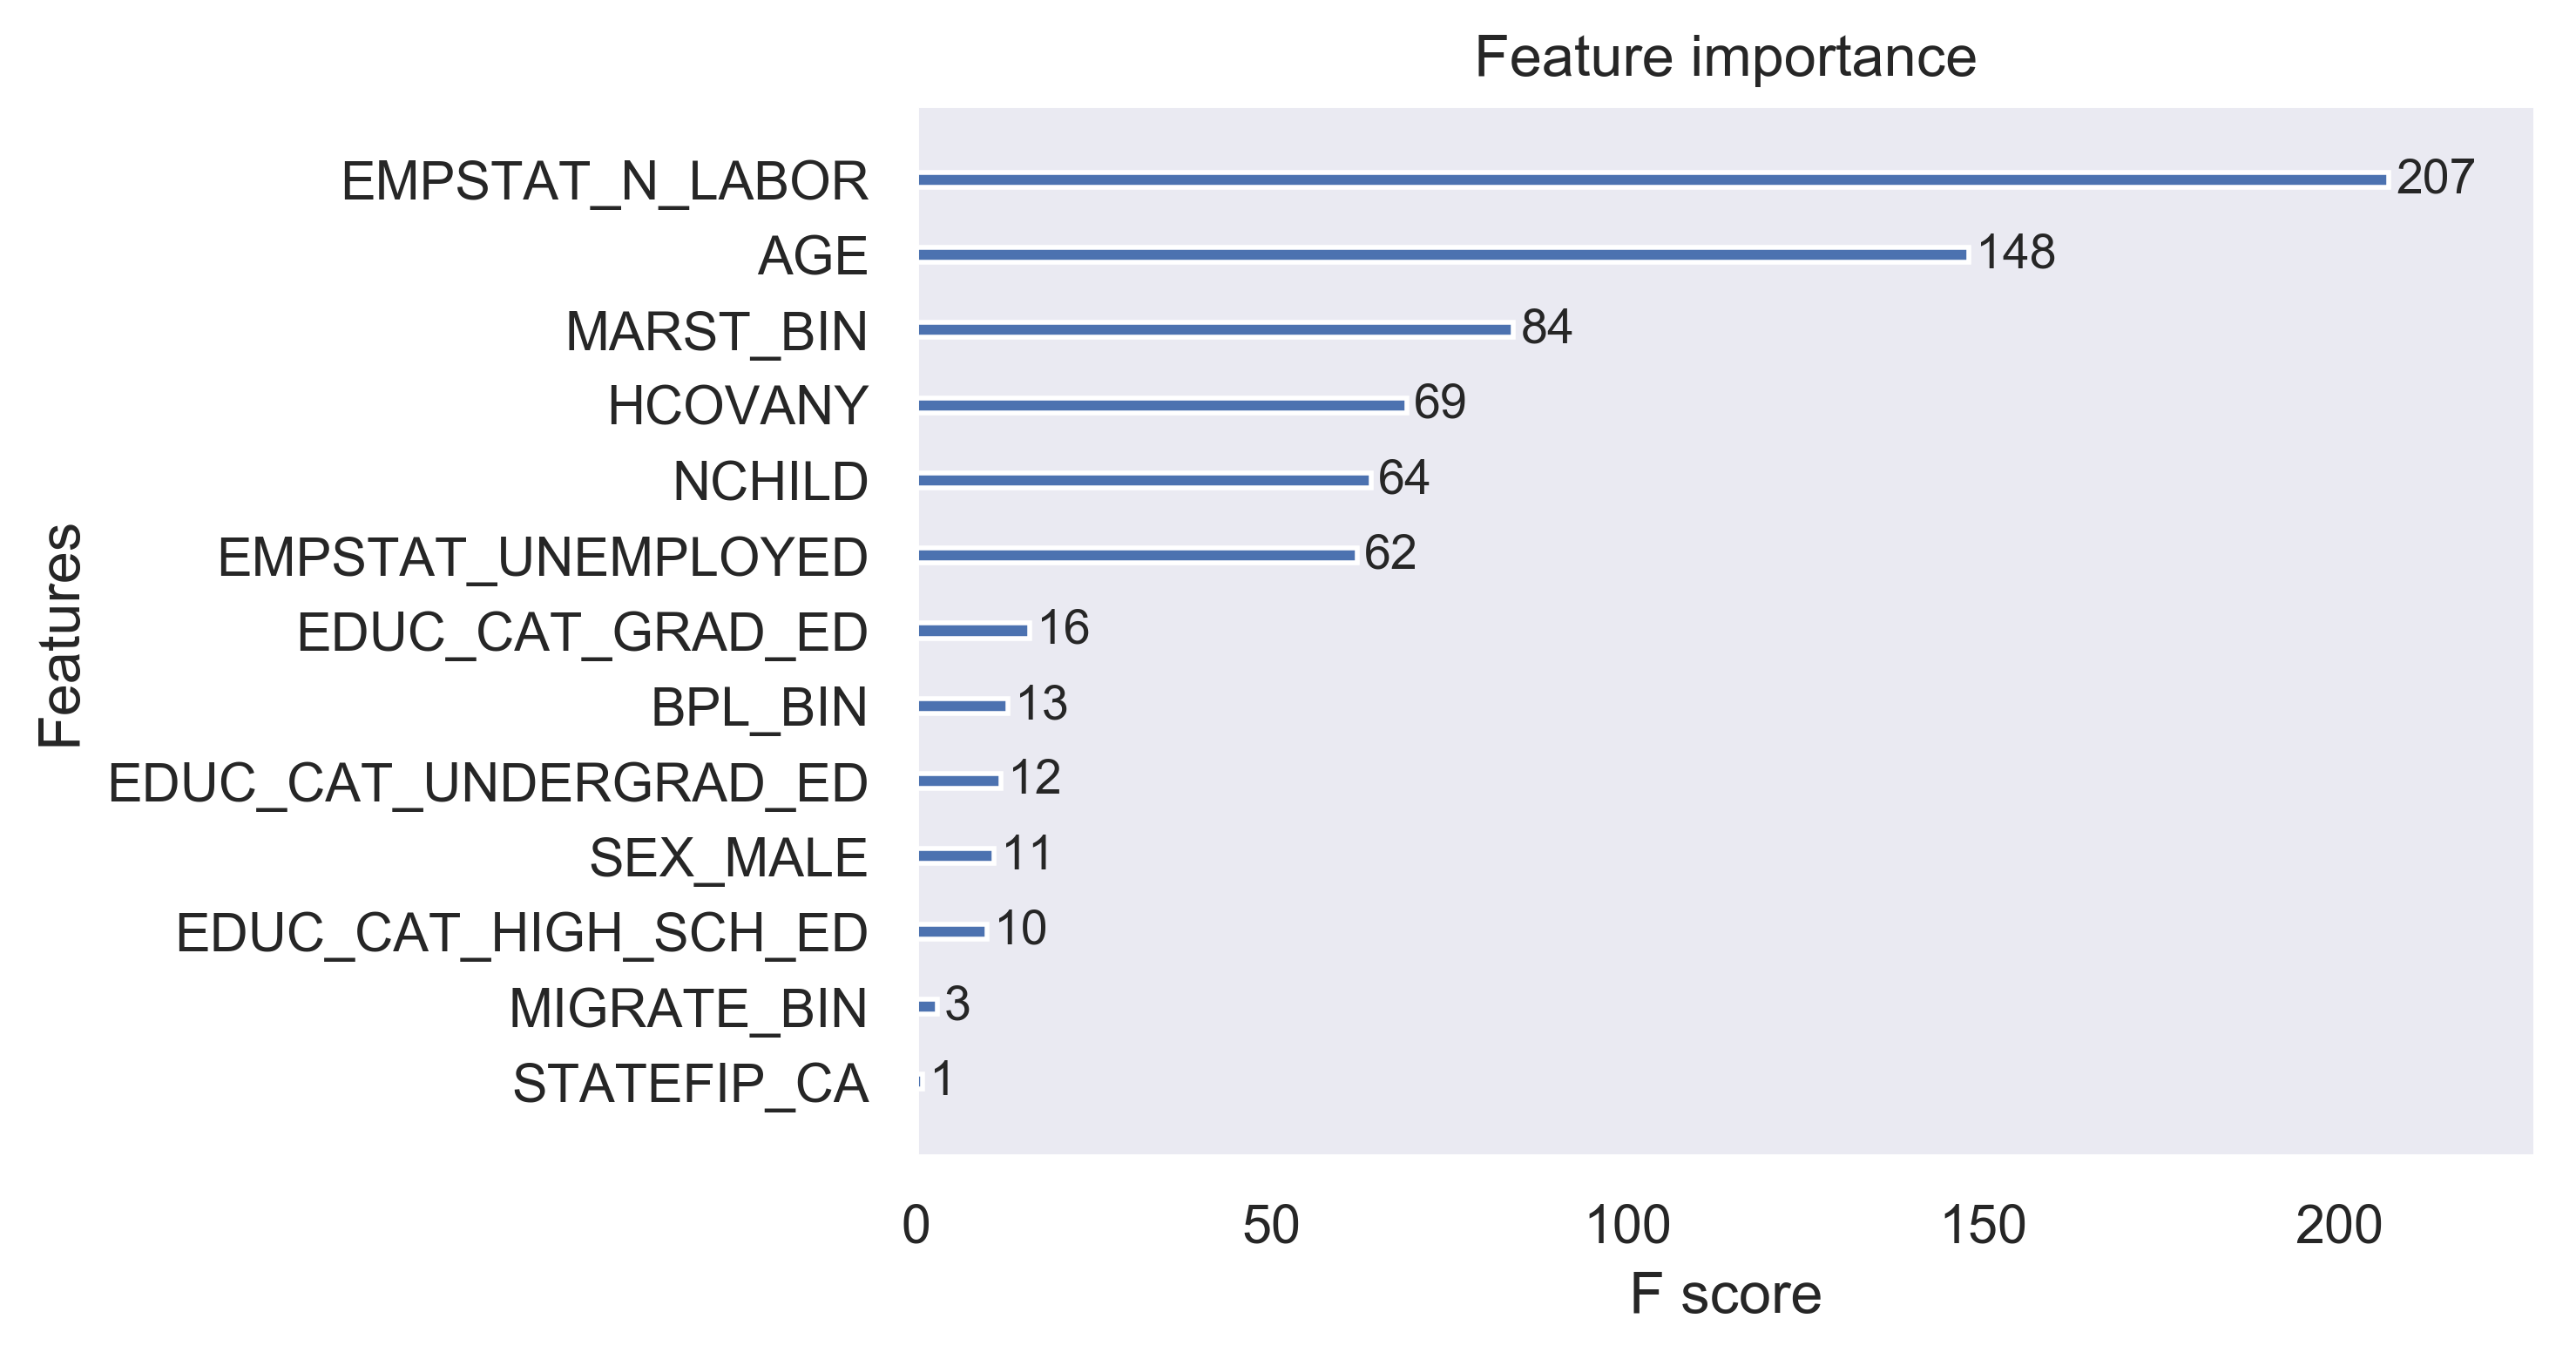

In [77]:
plt.rcParams["figure.dpi"] = 200
plt.figure(figsize=(18,10))

ax = plot_importance(xgb, grid = False)
ax.xlabel('Features', fontsize = 25);

# Saves the figure
plt.savefig("Importance.png", format="png", bbox_inches='tight', transparent = True)

<Figure size 5400x3000 with 0 Axes>

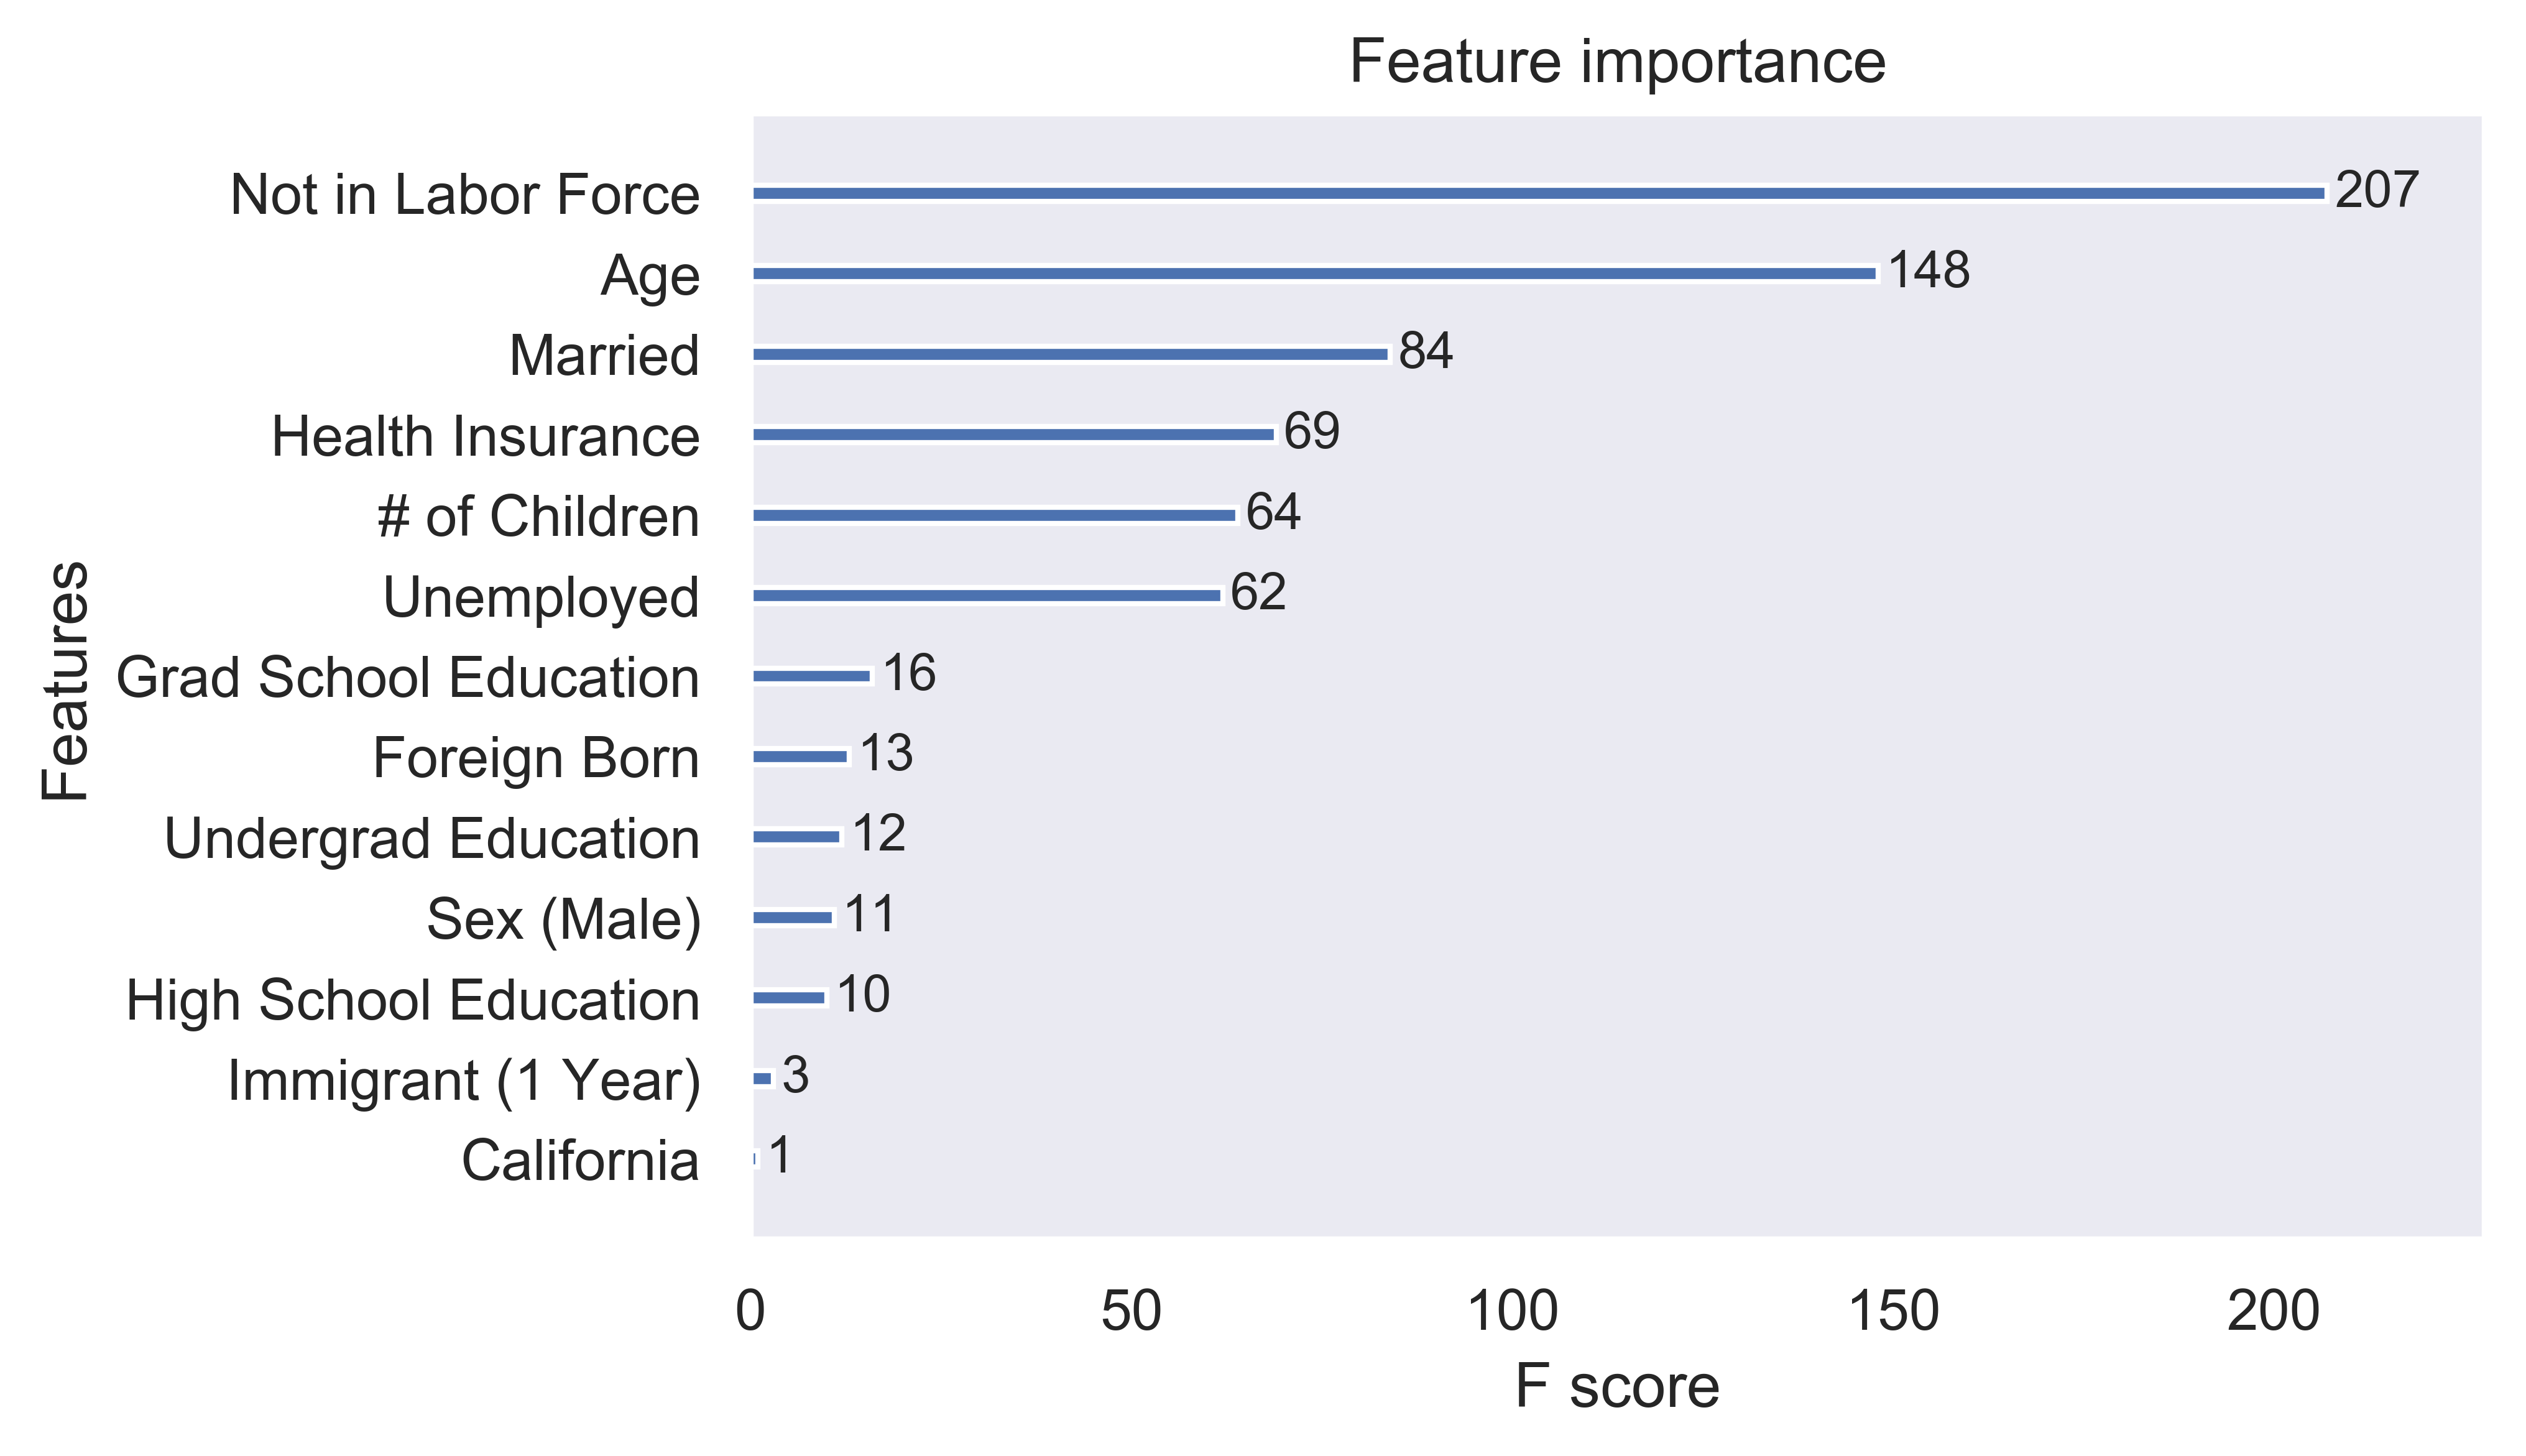

In [91]:
plt.rcParams["figure.dpi"] = 300
plt.figure(figsize=(18,10))

ax = plot_importance(new_dict, grid = False)

# Saves the figure
plt.savefig("Importance.png", format="png", bbox_inches='tight', transparent = True)